Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

In [3]:
df = pd.read_csv(r"C:\Users\Tricia Ezhilarasi  J\Downloads\fer2013.csv\fer2013.csv")
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

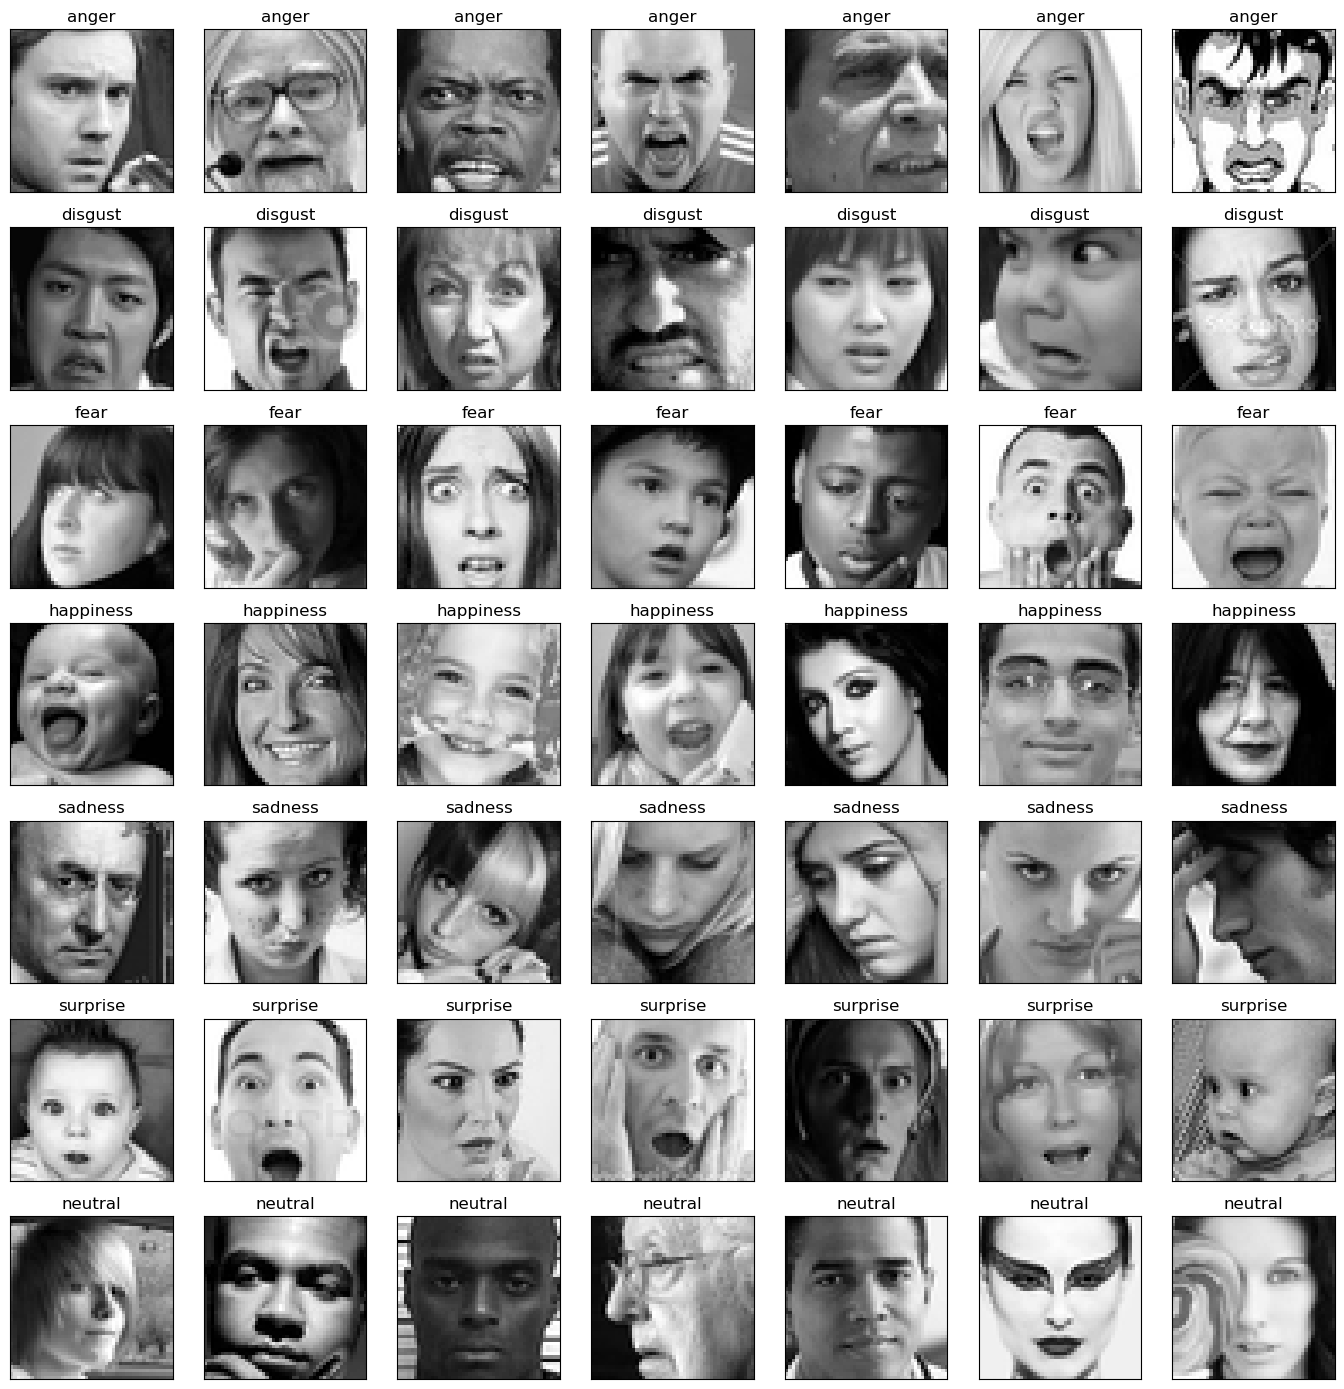

In [7]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [8]:
INTERESTED_LABELS = [0, 3, 4, 5, 6]

In [9]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(30219, 3)

In [ ]:
#making the data compatible for neural networks.

In [10]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [11]:
img_array.shape

(30219, 48, 48, 1)

In [12]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(30219, 5)

In [13]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 3: 1, 4: 2, 5: 3, 6: 4}


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((27197, 48, 48, 1), (3022, 48, 48, 1), (27197, 5), (3022, 5))

In [15]:
del df
del img_array
del img_labels

In [16]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [17]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [18]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [19]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [24]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [20]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [21]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)



Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0    

In [22]:
model.save('my_model.h5')

C:\Users\Tricia Ezhilarasi  J\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model.save_weights('my_model_weights.weights.h5')

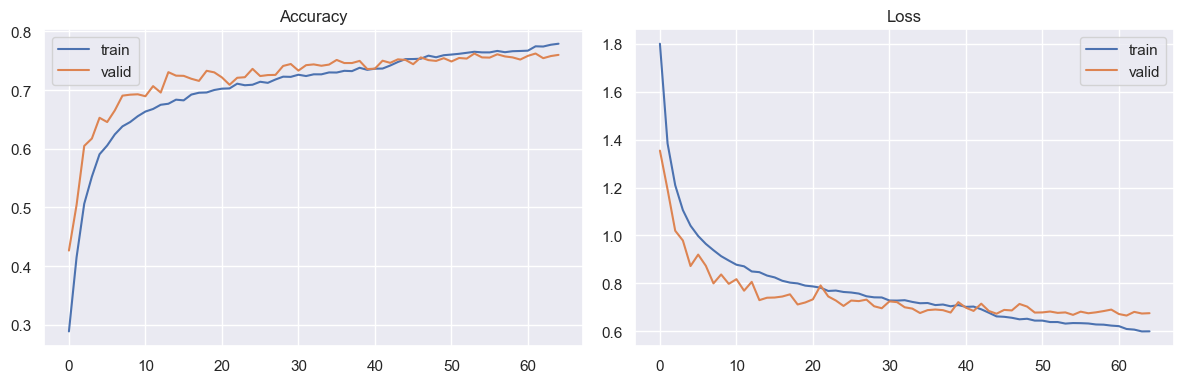

In [24]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=ax)
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=ax)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=ax)
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=ax)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [25]:
import numpy as np
import matplotlib.pyplot as pyplot
import scikitplot as skplt
from sklearn.metrics import classification_report

# Predict class probabilities
yhat_valid_prob = model.predict(X_valid)

# Convert probabilities to class labels
yhat_valid = np.argmax(yhat_valid_prob, axis=1)

# Convert true labels to class labels
y_true = np.argmax(y_valid, axis=1)

# Plot confusion matrix
fig, ax = pyplot.subplots(figsize=(7, 7))
skplt.metrics.plot_confusion_matrix(y_true, yhat_valid, ax=ax, cmap='Blues', normalize=True)
pyplot.title('Confusion Matrix')
pyplot.savefig("confusion_matrix_dcnn.png")

# Print the total number of wrong predictions
print(f'Total wrong validation predictions: {np.sum(y_true != yhat_valid)}\n\n')

# Print classification report
print(classification_report(y_true, yhat_valid))

ModuleNotFoundError: No module named 'scikitplot'

In [27]:
mapper = {
    0: "anger",
    1: "happy",
    2: "sad",
    3: "surprise",
    4: "neutral",
}

1/1 [==============================] - 0s 20ms/step


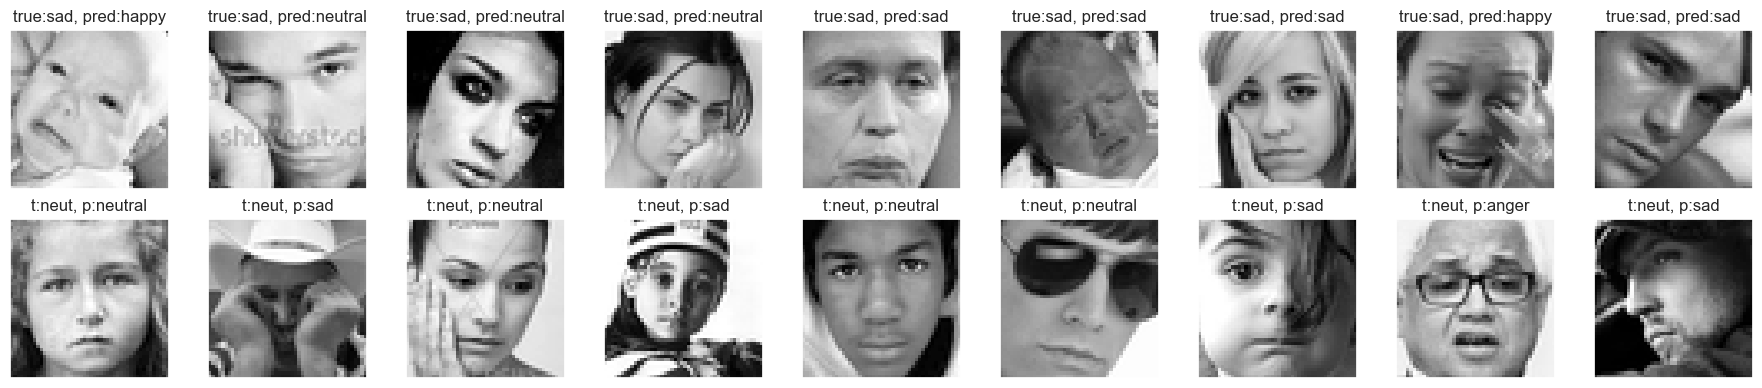

In [28]:
import numpy as np
import matplotlib.pyplot as pyplot

np.random.seed(2)

# Get random indices for sad and neutral images
random_sad_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

# Plot random sad images
for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    # Plot sad image
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Predict the class
    pred_class = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]
    ax.set_title(f"true:sad, pred:{mapper[pred_class]}")

    # Plot neutral image
    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Predict the class
    pred_class = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]
    ax.set_title(f"t:neut, p:{mapper[pred_class]}")

pyplot.tight_layout()
pyplot.show()

1/1 [==============================] - 0s 30ms/step


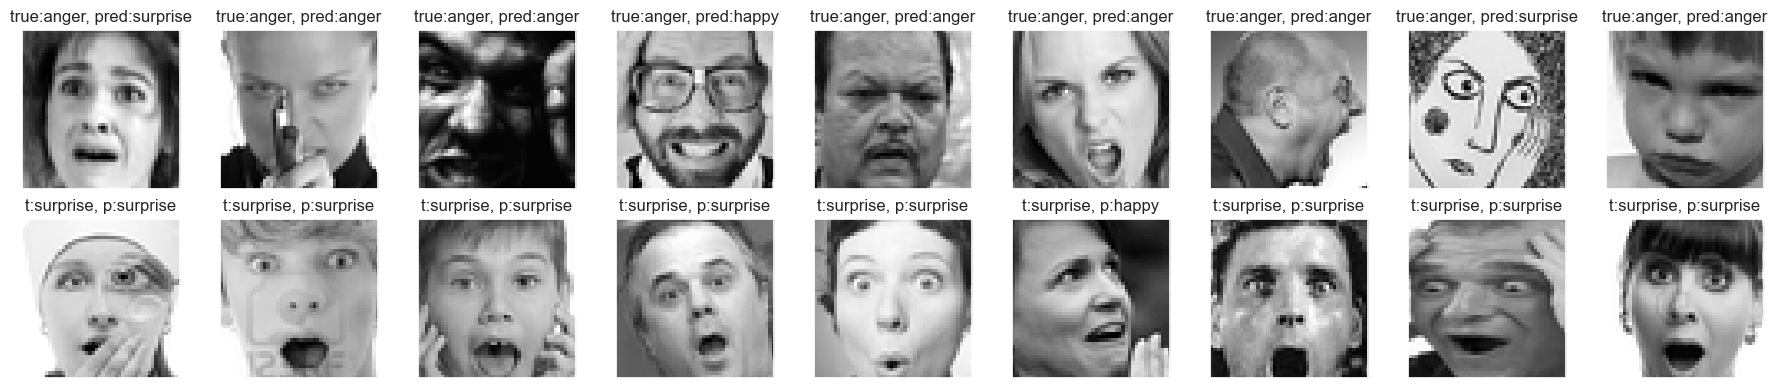

In [29]:
import numpy as np
import matplotlib.pyplot as pyplot

np.random.seed(2)

# Get random indices for anger and surprise images
random_anger_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)
random_surprise_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

# Plot random images
for i, (angidx, supidx) in enumerate(zip(random_anger_imgs, random_surprise_imgs)):
    # Plot anger image
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[angidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Predict the class
    pred_class = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]
    ax.set_title(f"true:anger, pred:{mapper[pred_class]}")

    # Plot surprise image
    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[supidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Predict the class
    pred_class = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]
    ax.set_title(f"t:surprise, p:{mapper[pred_class]}")

pyplot.tight_layout()
pyplot.show()